# Quantifying the Spatial Gradient of Suppression
## Used in "Target templates and the time course of distractor location learning"
### A. A. Hanne, J. Tünnermann & A. Schubö

This notebook provides the code for fitting the spatial decay of suppression of the form

$$ \Delta RT(x) = (1-\exp^{(-r\cdot x)})\cdot (m-d)+d $$

where RT is the predicted response time at distance $x$, $r$ is the spatial gradient of suppression rate which models how fast suppression decreases across the visual field, $m$ is the distractor cost outside the suppression range (i.e., the level of maximum interference by the distractor to which the curve converges) and $d$ is the distractor cost at the location of highest suppression.

Due to the stochastic nature of MCMC sampling, the results depicted in this notebook might differ slightly numerically from the values reported in the paper.

This notebook can sample the traces (this takes long) or load them from disk. You can download our traces from https://osf.io/5wcex/ and copy them in the traces/ subfolder.

### Import Python packages

In [7]:
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import pymc as pm
import arviz as az
from arviz.plots.plot_utils import calculate_point_estimate
import matplotlib.pyplot as plt
import aesara.tensor as at
import numpy as np
from matplotlib import cm
import os

### Load data

In [8]:
taskdata = {}
for task in ['singleton', 'feature-specific']:
    data = pd.read_csv('data/Dataset_SpatialGradientOfSuppression.csv', sep=';', decimal=',')
    data = data[data['task']==task]
    data_distractor_absent = data[data['distractor_condition'] == 'distractor_absent']
    
    baseline_data = data_distractor_absent.groupby(['participant_number']).mean()['RT'].reset_index()
    sub_baselines = baseline_data.set_index('participant_number')['RT'].to_dict()
        
    for index, row in  tqdm(data.iterrows(), desc='Subtracting baseline from RTs'):
        data.at[index, 'Inhibition_Diff'] = row['RT'] - sub_baselines[row['participant_number']] 

    data=data[data['distractor_condition'] != 'distractor_absent']
    
    # Renumber participants
    data['participant_index'] = (data['participant_number'].rank(method ='dense')-1).astype(int)
    
   
    taskdata[task] = data
        
display(data)

Subtracting baseline from RTs: 7307it [00:00, 15577.74it/s]
Subtracting baseline from RTs: 8729it [00:00, 16662.64it/s]


,participant_number,RT,distractor_condition,distance,task,Inhibition_Diff,participant_index
7307,112,633,high,0.00,feature-specific,-82.445161,0
7308,112,830,high,0.00,feature-specific,114.554839,0
7309,112,758,high,0.00,feature-specific,42.554839,0
7310,112,830,high,0.00,feature-specific,114.554839,0
7311,112,777,high,0.00,feature-specific,61.554839,0
...,...,...,...,...,...,...,...
16011,149,926,low,7.85,feature-specific,146.212121,9
16012,149,676,low,4.25,feature-specific,-103.787879,9
16013,149,498,low,10.30,feature-specific,-281.787879,9
16014,149,968,low,10.30,feature-specific,188.212121,9


### Define the spatial decay curve

In [9]:
def suppression(x, r, m, d, exp_func=at.exp):
    '''See top of the notebook for parameter meanings'''
    return (1 - exp_func(-r * x)) * (m - d) + d

### Define the model

In [10]:
distances_s = taskdata['singleton']['distance'].values
distances_f = taskdata['feature-specific']['distance'].values

participants_f = taskdata['feature-specific']['participant_index'].values
participants_s = taskdata['singleton']['participant_index'].values

with pm.Model() as model:
    
    max_impair_mu  = pm.Normal('max_impair_mu', mu=29.6, sigma=19.6)
    max_impair_sd  = pm.Uniform('max_impair_sd', 0, 20)
    max_impair_z_f =   pm.Normal('max_impair_e_f', 0,1, shape=len(set(participants_f)))
    max_impair_z_s =   pm.Normal('max_impair_e_s', 0,1, shape=len(set(participants_s)))
    
    rate_mu_f  = pm.HalfNormal('rate_mu_f', 0.1)
    rate_sd_f  = pm.Uniform('rate_sd_f', 0, 0.1)
    rate_z_f = pm.Normal('rate_e_f', 0,1,shape=len(set(participants_f)))
 
    rate_mu_s  = pm.HalfNormal('rate_mu_s', 0.1)
    rate_sd_s  = pm.Uniform('rate_sd_s', 0, 0.1)
    rate_z_s = pm.Normal('rate_e_s', 0,1,shape=len(set(participants_s)))
    
    d_mu  = pm.Normal('d_mu', 10, 5)
    d_sd  = pm.Uniform('d_sd', 0, 5)
    d_z_s = pm.Normal('d_e_s', 0, 1,shape=len(set(participants_s)))
    d_z_f = pm.Normal('d_e_f', 0, 1, shape=len(set(participants_f)))
      
    sd_mu = pm.Uniform('sd_mu', 0, 100)
    sd_sd  = pm.HalfCauchy('sd_sd', 0.1)
    sd_z_f = pm.Normal('sd_e_f', 0,1, shape=len(set(participants_f)))
    sd_z_s = pm.Normal('sd_e_s', 0,1, shape=len(set(participants_s)))
   
    rate_f = pm.Deterministic('rate_f', rate_mu_f + rate_z_f * rate_sd_f)
    rate_s = pm.Deterministic('rate_s', rate_mu_s + rate_z_s * rate_sd_s)

    max_impair_f = pm.Deterministic('max_impair_f', max_impair_mu + max_impair_z_f * max_impair_sd)
    max_impair_s = pm.Deterministic('max_impair_s', max_impair_mu + max_impair_z_s * max_impair_sd)
    
    d_f = pm.Deterministic('d_f', d_mu + d_z_f * d_sd)
    d_s = pm.Deterministic('d_s', d_mu + d_z_s * d_sd)
    
    sd_f = pm.Deterministic('sd_f', sd_mu + sd_z_f * sd_sd).clip(0, np.inf)
    sd_s = pm.Deterministic('sd_s', sd_mu + sd_z_s * sd_sd).clip(0, np.inf)
                                     
    course_f = pm.Deterministic('course_f', suppression(distances_f, rate_f[participants_f], 
                                                       max_impair_f[participants_f],
                                                       d_f[participants_f]))
    course_s = pm.Deterministic('course_s', suppression(distances_s, rate_s[participants_s],
                                                       max_impair_s[participants_s], 
                                                       d_s[participants_s]))
     
    y_f = pm.Normal('y_f', mu=course_f, sigma=sd_f[participants_f],
                    observed=taskdata['feature-specific']['Inhibition_Diff'])
    y_s = pm.Normal('y_s', mu=course_s, sigma=sd_s[participants_s],
                    observed=taskdata['singleton']['Inhibition_Diff'])
    
    rate_diff = pm.Deterministic('rate_diff', rate_mu_s - rate_mu_f)  

### Run the model (or load samples from disk)

In [11]:
with model:
    if not os.path.isfile('traces/trace_spatialgradient.nc'):
        trace = pm.sample(20000, tune=10000, target_accept=0.999, init='adapt_diag') 
        trace.to_netcdf("traces/trace_spatialgradient.nc")
    else:
        print('Loading spatial_gradient.nc from disk! Delete/rename the existing' +
              'file if you want to fit newly instead of loading')
        trace = az.from_netcdf("traces/trace_spatialgradient.nc")

Loading spatial_gradient.nc from disk! Delete/rename the existingfile if you want to fit newly instead of loading


### Convergence diagnostics

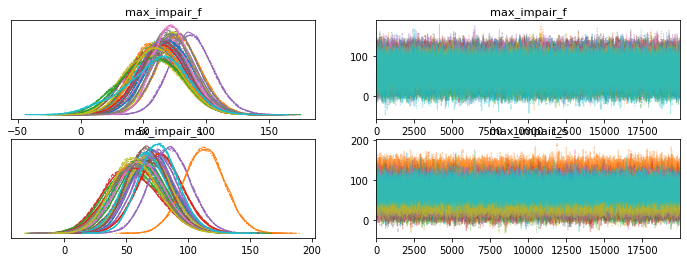

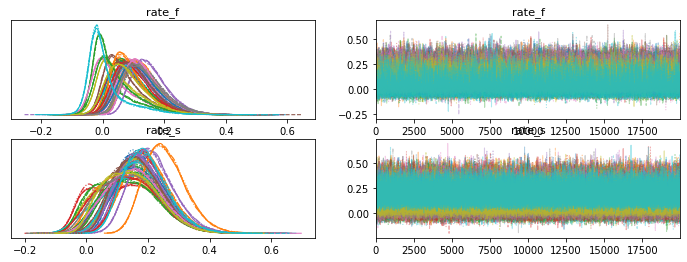

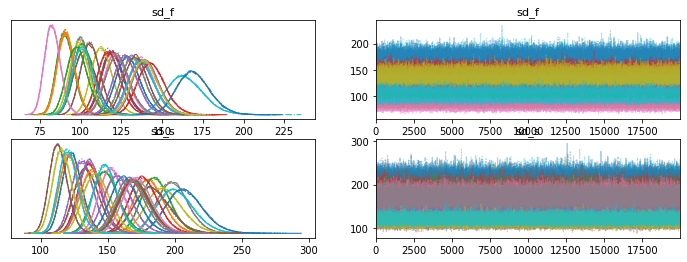

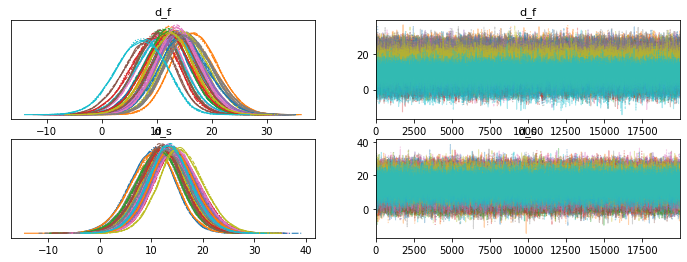

In [12]:
with model:
    az.plot_trace(trace, var_names=['max_impair_f', 'max_impair_s'])
    az.plot_trace(trace, var_names=['rate_f', 'rate_s'])
    az.plot_trace(trace, var_names=['sd_f', 'sd_s'])
    az.plot_trace(trace, var_names=['d_f', 'd_s'])

### Get a summary table of the model estimates

In [13]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
max_impair_mu,66.647,10.274,48.036,86.082,0.105,0.074,9354.0,21061.0,1.0
max_impair_e_f[0],0.113,0.886,-1.552,1.778,0.003,0.003,80110.0,59083.0,1.0
max_impair_e_f[1],-0.339,0.901,-1.979,1.411,0.004,0.003,65346.0,56897.0,1.0
max_impair_e_f[2],-0.521,1.102,-2.562,1.515,0.007,0.005,26826.0,52158.0,1.0
max_impair_e_f[3],-0.004,0.900,-1.684,1.699,0.003,0.003,89980.0,59622.0,1.0
...,...,...,...,...,...,...,...,...,...
course_s[3515],42.058,15.846,12.710,72.149,0.051,0.038,95332.0,63224.0,1.0
course_s[3516],45.702,17.588,13.230,78.414,0.057,0.042,93784.0,64122.0,1.0
course_s[3517],33.400,11.867,11.446,56.364,0.039,0.029,90680.0,66106.0,1.0
course_s[3518],45.702,17.588,13.230,78.414,0.057,0.042,93784.0,64122.0,1.0


### Plot the estimates

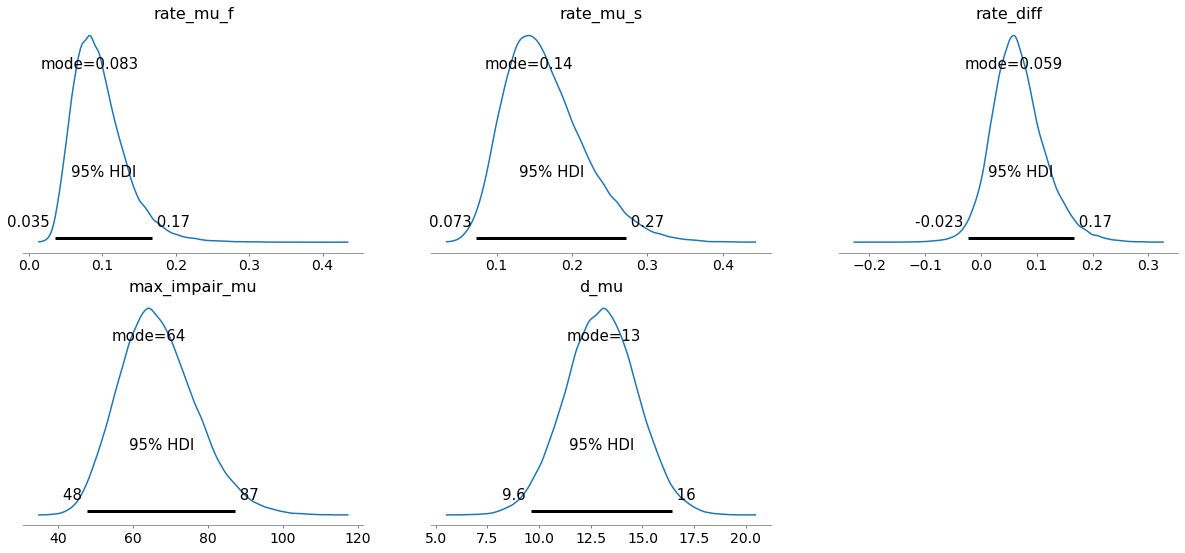

In [14]:
with model:
    az.plot_posterior(trace, var_names=['rate_mu_f', 'rate_mu_s', 
                                        'rate_diff', 'max_impair_mu', 'd_mu'],
                      point_estimate='mode', hdi_prob=0.95)

### Visualizing the priors relative to the posteriors

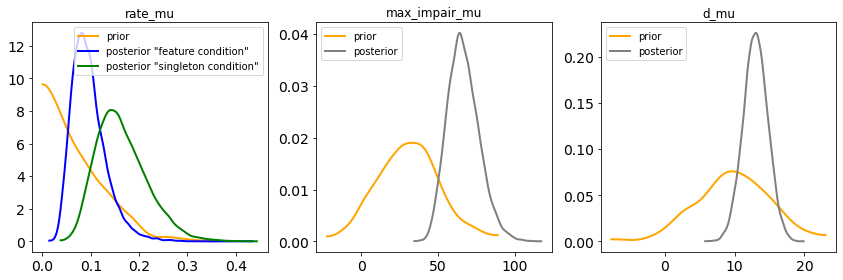

In [15]:
with model:
    trace.extend(pm.sample_prior_predictive())

f, axs = plt.subplots(1,3, figsize=(12,4))

rate_mu_prior = trace.prior['rate_mu_f'][0]
az.plot_dist(rate_mu_prior[rate_mu_prior < 0.5], color='orange', ax=axs[0],
             plot_kwargs={'lw':2, 'label':'prior'})    
az.plot_dist(trace.posterior['rate_mu_f'][0], ax=axs[0],
             plot_kwargs={'lw':2, 'label':'posterior "feature condition"'}, color = "blue")    
az.plot_dist(trace.posterior['rate_mu_s'][0], ax=axs[0],
             plot_kwargs={'lw':2, 'label':'posterior "singleton condition"'}, color = "green") 
axs[0].set_title('rate_mu')
axs[0].legend(loc='upper right')

max_impair_prior = trace.prior['max_impair_mu'][0]
az.plot_dist(max_impair_prior[max_impair_prior < 120], color='orange', ax=axs[1], plot_kwargs={'lw':2, 'label':'prior'})    
az.plot_dist(trace.posterior['max_impair_mu'][0],  ax=axs[1], plot_kwargs={'lw':2, 'label':'posterior'}, color = "grey")    
axs[1].set_title('max_impair_mu')
axs[1].legend()


d_prior = trace.prior['d_mu'][0]
az.plot_dist(d_prior[d_prior < 25], color='orange', ax=axs[2], plot_kwargs={'lw':2, 'label':'prior'})    
az.plot_dist(trace.posterior['d_mu'][0],  ax=axs[2], plot_kwargs={'lw':2, 'label':'posterior'}, color = "grey")    
axs[2].set_title('d_mu')
axs[2].legend()

plt.tight_layout()
plt.savefig('figures/FigureS4.svg')

### Plot spatial decay curves
Sample posterior predictive distribution. This may take a while

In [16]:
# Only use every 10th sample (to speed up pp sampling):
thinned_trace = trace.posterior.sel(draw = slice(0,None,10)) 
ppc_trace = pm.sample_posterior_predictive(thinned_trace, model=model, keep_size=True)

Extend dataframe, aggregate and lineplot visualization:

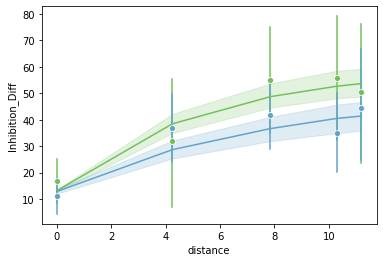

In [17]:
means_s = np.mean(ppc_trace.posterior_predictive['y_s'], axis=(0,1))
means_f = np.mean(ppc_trace.posterior_predictive['y_f'], axis=(0,1))
taskdata['singleton']['predicted_means_singleton'] = means_s
taskdata['feature-specific']['predicted_means_feature'] = means_f

agg_data_singleton = taskdata['singleton'].groupby(['participant_index','distance']).mean()
agg_data_feature = taskdata['feature-specific'].groupby(['participant_index','distance']).mean()

sns.lineplot(data=agg_data_singleton, x='distance', y='Inhibition_Diff', 
             marker='o', linestyle='', err_style='bars', color='#72c05b')
sns.lineplot(data=agg_data_feature, x='distance', y='Inhibition_Diff',
             marker='o', linestyle='', err_style='bars', color="#62a3cc")
sns.lineplot(data=agg_data_singleton, x='distance', y='predicted_means_singleton',
             color='#72c05b')
sns.lineplot(data=agg_data_feature, x='distance', y='predicted_means_feature',
             color= "#62a3cc")
plt.savefig('figures/FigureS1.svg')

Plot 2D representation of suppression map:

100%|██████████| 3450/3450 [01:13<00:00, 46.92it/s]


Parameter values: 
r = 0.112755 
d = 13.124312 
m = 64.164543


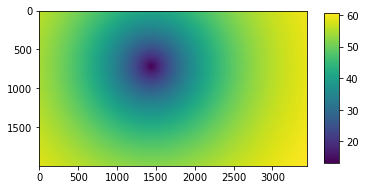

In [19]:
ppcm = 100 #pixel pro cm

x_size = int(34.5 * ppcm)
y_size = int(20 * ppcm)

display_size = [y_size, x_size] 
img = np.zeros(display_size)
img.fill(255)

high_position = [14.45 * ppcm, 7.2 * ppcm]

# Get parameters from posterior means:
#r = calculate_point_estimate('mode',trace.posterior['rate_mu_f'].values)   # feature
#r = calculate_point_estimate('mode',trace.posterior['rate_mu_s'].values)   # singleton
r = 0.5 * (calculate_point_estimate('mode',trace.posterior['rate_mu_f'].values) +
           calculate_point_estimate('mode',trace.posterior['rate_mu_s'].values))
d = calculate_point_estimate('mode',trace.posterior['d_mu'].values)    
m = calculate_point_estimate('mode',trace.posterior['max_impair_mu'].values)    


for x in tqdm(range(display_size[1])): 
    for y in range(display_size[0]):
        p1 = np.array(high_position)/ppcm
        p2 = np.array([x,y])/ppcm
        distance = np.linalg.norm(p1-p2)
        value = suppression(distance, r, m, d, exp_func=np.exp)
        img[y,x] = value

print('Parameter values: \n' +
      'r = %f \nd = %f \nm = %f'%(r, d, m))


plt.imshow(img)
plt.colorbar(shrink=0.69, aspect=10)


Plot 3D visualization of suppression map:

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: The following kwargs were not used by contour: 'xdir'
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: The following kwargs were not used by contour: 'ydir'


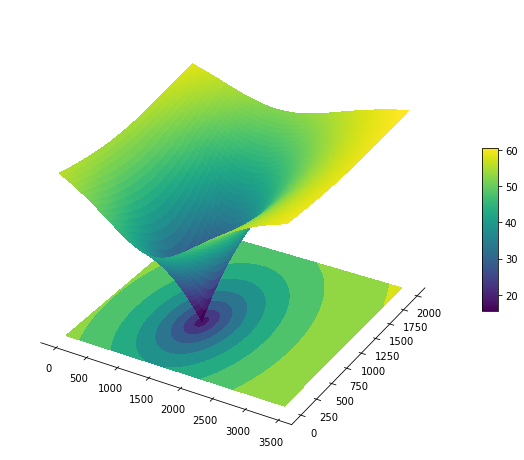

In [20]:
y = np.arange(0,y_size,1)
x = np.arange(0,x_size,1)
X,Y = np.meshgrid(x,y)
Z = img

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')


ax.xaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.fill = False
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.fill = False
ax.zaxis.pane.set_edgecolor('white')
ax.grid(False)
ax.w_zaxis.line.set_lw(0.)
ax.set_zticks([])


# Color
surf = ax.plot_surface(X, Y, Z,
                        cmap=plt.cm.viridis,
                        linewidth=0,
                        antialiased=False)

# 2D contour plot
cset = ax.contourf(X, Y, Z, zdir='z', offset=np.min(Z), cmap=cm.viridis)
cset = ax.contourf(X, Y, Z, xdir='x', offset=x_size, cmap=cm.viridis)
cset = ax.contourf(X, Y, Z, ydir='y', offset=y_size, cmap=cm.viridis)

cbar = fig.colorbar(surf, shrink=0.3, aspect=10)
plt.savefig('figures/Figure4_raw.svg')